In [3]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import svm, metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import os
import seaborn as sns
import datetime
import progressbar
from time import sleep
import scipy.signal as signal 
import sys
sys.path.append('../')
from detect_peaks import detect_peaks
from collections import Counter
sns.set(style="darkgrid")
from Build_LSTM import *


In [2]:
def get_class_weights(y):
    y = np.asarray(y)
    from sklearn.utils import class_weight
    class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y.reshape(y.shape[0],))
                                               ,y.reshape(y.shape[0],))
    return  {cls: float(weight) for cls,weight in zip (np.unique(y.reshape(y.shape[0],)),class_weight)}


In [4]:
def auc_roc_plot(y_test, y_score, classes  = 'all'):
    from sklearn.metrics import roc_curve, auc
    if classes is None:
        classes = list(range(y_test.shape[1]))
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(classes, colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    

In [5]:
def plot_cm(cm, classes, normalize = True):
    import seaborn as sns
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes[::-1]);
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    plt.show()

In [6]:
df = pd.read_csv("/home/ahmet/notebooks/data/G9_data/processed.csv")
df.dropna(axis=0, how='any', inplace=True)

In [7]:
df.head()

,CorAccXAccY_corr,CorAccXAccZ_corr,CorAccYAccZ_corr,CorGyroXGyroY_corr,CorGyroXGyroZ_corr,CorGyroYGyroZ_corr,accX_aoa,accX_apf,accX_ate,accX_max,...,gyroZ_ate,gyroZ_max,gyroZ_mean,gyroZ_min,gyroZ_minmax,gyroZ_rms,gyroZ_std,label,start,subject_id
0,-0.203308,-0.006418,-0.306709,0.729442,0.466242,0.564335,-6.157835,0.032258,32.600,-6.009446,...,33.200000,0.017993,0.000393,-0.018226,0.036219,0.007702,0.007692,5.0,2018-01-16 06:30:12.021,15.0
1,0.183600,0.268280,0.116951,0.670981,-0.496039,-0.265089,-9.690440,0.030457,36.600,-8.925584,...,25.000000,0.390070,-0.023285,-0.391834,0.781904,0.199077,0.197711,5.0,2017-12-20 07:21:47.026,11.0
2,0.287355,-0.307794,-0.668631,-0.082595,0.327066,0.308276,-9.610062,0.033088,30.625,-9.457097,...,24.900000,0.056933,0.000707,-0.028820,0.085754,0.011482,0.011461,5.0,2018-01-16 04:35:14.010,14.0
3,0.157467,-0.363985,-0.238422,0.587318,-0.158445,-0.446905,-9.600425,0.030405,34.000,-9.270349,...,31.666667,0.191847,-0.037042,-0.200170,0.392017,0.097071,0.089726,5.0,2017-12-08 09:29:15.016,1.0
4,-0.088482,0.206576,0.844334,0.626280,-0.476421,-0.400950,-4.999800,0.028409,33.500,-4.831499,...,33.800000,0.057916,-0.001206,-0.048611,0.106526,0.018725,0.018686,5.0,2018-01-16 04:04:24.018,13.0


/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,u'Label')

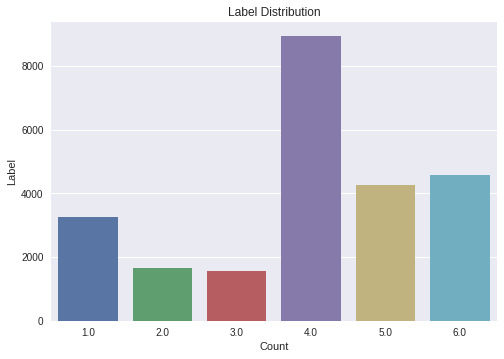

In [9]:
sns.countplot(x="label",data=df)
plt.title("Label Distribution")
plt.xlabel("Count")
plt.ylabel("Label")

In [12]:
df.columns[:-3]

Index([u'CorAccXAccY_corr', u'CorAccXAccZ_corr', u'CorAccYAccZ_corr',
       u'CorGyroXGyroY_corr', u'CorGyroXGyroZ_corr', u'CorGyroYGyroZ_corr',
       u'accX_aoa', u'accX_apf', u'accX_ate', u'accX_max', u'accX_mean',
       u'accX_min', u'accX_minmax', u'accX_rms', u'accX_std', u'accY_aoa',
       u'accY_apf', u'accY_ate', u'accY_max', u'accY_mean', u'accY_min',
       u'accY_minmax', u'accY_rms', u'accY_std', u'accZ_aoa', u'accZ_apf',
       u'accZ_ate', u'accZ_max', u'accZ_mean', u'accZ_min', u'accZ_minmax',
       u'accZ_rms', u'accZ_std', u'gyroX_aoa', u'gyroX_apf', u'gyroX_ate',
       u'gyroX_max', u'gyroX_mean', u'gyroX_min', u'gyroX_minmax',
       u'gyroX_rms', u'gyroX_std', u'gyroY_aoa', u'gyroY_apf', u'gyroY_ate',
       u'gyroY_max', u'gyroY_mean', u'gyroY_min', u'gyroY_minmax',
       u'gyroY_rms', u'gyroY_std', u'gyroZ_aoa', u'gyroZ_apf', u'gyroZ_ate',
       u'gyroZ_max', u'gyroZ_mean', u'gyroZ_min', u'gyroZ_minmax',
       u'gyroZ_rms', u'gyroZ_std'],
      dtype='obj

In [212]:
#LOO-Validation on each subject
subject_list = np.unique(df['subject_id'])
y_test_all = []
y_pred_all = []
y_score_all = []
iterations = list(itertools.combinations(subject_list, 2))
size = len(iterations)/8 # to speed up simulations
it_index = np.random.choice(len(iterations), size=size, replace = False)

# initialization of Bar 
bar = progressbar.ProgressBar(maxval=size, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
bar.update(0)
bar_i = 0
for i in range(size): # two combination of tested subjects
    
    subject = iterations[i]
    print("==================")
    print('Model tested on subjects with no : ', subject)
    df_training = df[np.logical_and(df['subject_id']!=subject[0],df['subject_id']!=subject[1] )]
    df_test = df[np.logical_or(df['subject_id']==subject[0], df['subject_id']==subject[1] )]
    print("Test set and training set proportion : ",float(df_test.shape[0])/df_training.shape[0] )
    X_test = df_test[df_test.columns[:-3]].values
    y_test = df_test['label'].values
    X_training = df_training[df_training.columns[:-3]].values
    y_training = df_training['label'].values
    
    # Calculate class weight
#     from sklearn.utils import compute_class_weight
#     class_weight = compute_class_weight('balanced', label_dict.keys(), y_training)
#     class_weight ={cls: float(weight) for cls,weight in zip (label_dict.keys(),class_weight)}
    class_weight = get_class_weights(y_training)
    
    
    # model definition
    model = LogisticRegression()
#     model = svm.SVC( class_weight = class_weight)
    model.fit(X_training, y_training)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    y_score_all.extend(y_score)
    y_test_all.extend(list(y_test))
    y_pred_all.extend(list(np.argmax(pd.rolling_mean( y_score, 30,min_periods=1), axis=1)+1))
    bar.update(bar_i+1)
    bar_i += 1
bar.finish()

[                                                                        ] N/A%

Model tested on subjects with no :  (1.0, 3.0)
Test set and training set proportion :  0.0926067587634


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
[==                                                                      ]   2%

Model tested on subjects with no :  (1.0, 4.0)
Test set and training set proportion :  0.0991353945045


[====                                                                    ]   5%

Model tested on subjects with no :  (1.0, 5.0)
Test set and training set proportion :  0.0931970645176


[======                                                                  ]   8%

Model tested on subjects with no :  (1.0, 6.0)
Test set and training set proportion :  0.0945769282784


[========                                                                ]  11%

Model tested on subjects with no :  (1.0, 7.0)
Test set and training set proportion :  0.0947249774572


[==========                                                              ]  14%

Model tested on subjects with no :  (1.0, 8.0)
Test set and training set proportion :  0.0862038113984


[============                                                            ]  17%

Model tested on subjects with no :  (1.0, 9.0)
Test set and training set proportion :  0.0891271194043


[==============                                                          ]  20%

Model tested on subjects with no :  (1.0, 10.0)
Test set and training set proportion :  0.0985386599104


[================                                                        ]  23%

Model tested on subjects with no :  (1.0, 11.0)
Test set and training set proportion :  0.0932955108289


[===================                                                     ]  26%

Model tested on subjects with no :  (1.0, 13.0)
Test set and training set proportion :  0.090790655885


[=====================                                                   ]  29%

Model tested on subjects with no :  (1.0, 14.0)
Test set and training set proportion :  0.0931970645176


[=======================                                                 ]  32%

Model tested on subjects with no :  (1.0, 15.0)
Test set and training set proportion :  0.0944782510705


[=========================                                               ]  35%

Model tested on subjects with no :  (1.0, 16.0)
Test set and training set proportion :  0.0925084364454


[===========================                                             ]  38%

Model tested on subjects with no :  (1.0, 17.0)
Test set and training set proportion :  0.0940837200919


[=============================                                           ]  41%

Model tested on subjects with no :  (1.0, 18.0)
Test set and training set proportion :  0.0907416558106


[===============================                                         ]  44%

Model tested on subjects with no :  (1.0, 19.0)
Test set and training set proportion :  0.0916734106645


[=================================                                       ]  47%

Model tested on subjects with no :  (1.0, 20.0)
Test set and training set proportion :  0.0921153240678


[====================================                                    ]  50%

Model tested on subjects with no :  (1.0, 21.0)
Test set and training set proportion :  0.093246285457


[======================================                                  ]  52%

Model tested on subjects with no :  (1.0, 22.0)
Test set and training set proportion :  0.0910847488092


[========================================                                ]  55%

Model tested on subjects with no :  (1.0, 23.0)
Test set and training set proportion :  0.0978929281968


[==========================================                              ]  58%

Model tested on subjects with no :  (1.0, 24.0)
Test set and training set proportion :  0.093886561247


[============================================                            ]  61%

Model tested on subjects with no :  (1.0, 25.0)
Test set and training set proportion :  0.093886561247


[==============================================                          ]  64%

Model tested on subjects with no :  (1.0, 26.0)
Test set and training set proportion :  0.093344740634


[================================================                        ]  67%

Model tested on subjects with no :  (3.0, 4.0)
Test set and training set proportion :  0.0959602798465


[==================================================                      ]  70%

Model tested on subjects with no :  (3.0, 5.0)
Test set and training set proportion :  0.0900561167228


[====================================================                    ]  73%

Model tested on subjects with no :  (3.0, 6.0)
Test set and training set proportion :  0.0914280577156


[=======================================================                 ]  76%

Model tested on subjects with no :  (3.0, 7.0)
Test set and training set proportion :  0.0915752562489


[=========================================================               ]  79%

Model tested on subjects with no :  (3.0, 8.0)
Test set and training set proportion :  0.0831028637702


[===========================================================             ]  82%

Model tested on subjects with no :  (3.0, 9.0)
Test set and training set proportion :  0.0860094820646


[=============================================================           ]  85%

Model tested on subjects with no :  (3.0, 10.0)
Test set and training set proportion :  0.0953669869626


[===============================================================         ]  88%

Model tested on subjects with no :  (3.0, 11.0)
Test set and training set proportion :  0.0901539981143


[=================================================================       ]  91%

Model tested on subjects with no :  (3.0, 13.0)
Test set and training set proportion :  0.0876635011647


[===================================================================     ]  94%

Model tested on subjects with no :  (3.0, 14.0)
Test set and training set proportion :  0.0900561167228


[=====================================================================   ]  97%

Model tested on subjects with no :  (3.0, 15.0)
Test set and training set proportion :  0.0913299474134


[========================================================================] 100%


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


(0, 2902.5)

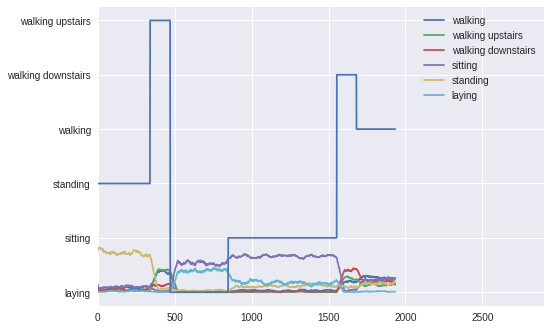

In [190]:
plt.plot(pd.rolling_mean( y_score, 50,min_periods=1), "-")
plt.xlim([0, 1.5*len(y_score)])
plt.legend(['walking',
        'walking upstairs',
        'walking downstairs',
        'sitting',
        'standing',
        'laying'], loc='upper_left')
a = np.asarray(y_test).astype(np.int)
y_ticks = np.asarray(LABELS)[a-1]
plt.plot(y_ticks)
plt.xlim([0, 1.5*len(y_score)])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


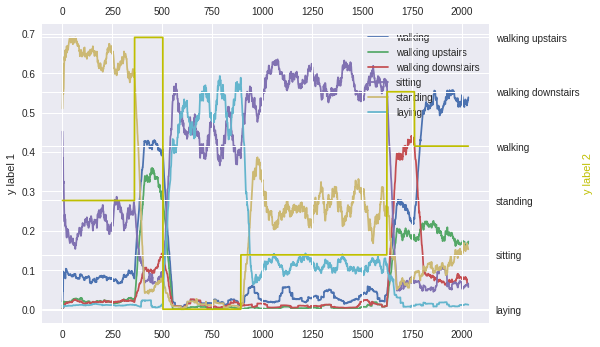

In [218]:
y_values1=pd.rolling_mean( y_score, 50,min_periods=1)

a = np.asarray(y_test).astype(np.int)
y_ticks = np.asarray(LABELS)[a-1]
y_values2=y_ticks


fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(y_values1)
ax.set_ylabel("y label 1")
ax.tick_params(axis='y')
ax.legend(['walking',
        'walking upstairs',
        'walking downstairs',
        'sitting',
        'standing',
        'laying'], loc='upper_left')

ax2.plot(y_values2, color  ='y')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right() 
ax2.set_ylabel('y label 2', color  ='y')       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', color  ='y')


plt.show()


In [181]:
label_dict = {1:'walking',
             2:'walking_upstairs',
             3:'walking_downstairs',
             4:'sitting',
             5:'standing',
             6:'laying'}
class_names = list(label_dict.values())

Confusion matrix, without normalization


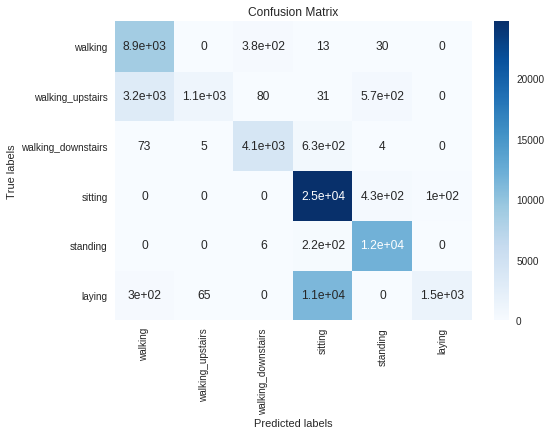

Normalized confusion matrix


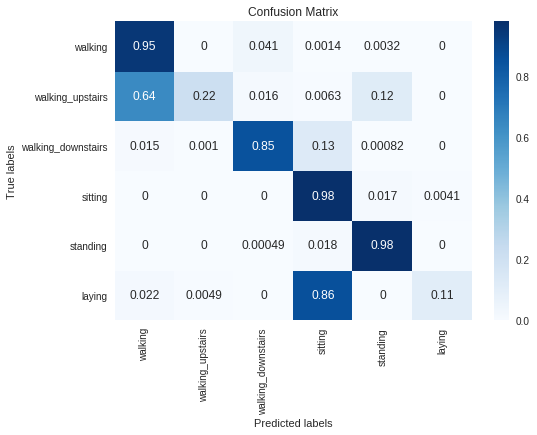

In [213]:
# save_with_name = "Results/EQ_SIZED_64_logreg-with-weights" ################################### 
cnf_matrix = confusion_matrix(y_test_all, y_pred_all)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=False)

# Plot normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=True)
# plt.savefig(save_with_name+'.png')
plt.show()

In [214]:
true_pos = np.diag(cnf_matrix).sum()
accuracy = true_pos/float(cnf_matrix.sum())
print('Overall accuracy of the Model', accuracy)

Overall accuracy of the Model 0.7498314904845903


In [215]:
from sklearn.metrics import classification_report
print(classification_report(y_test_all, y_pred_all,target_names=class_names))

                    precision    recall  f1-score   support

           walking       0.72      0.95      0.82      9316
  walking_upstairs       0.94      0.22      0.35      4905
walking_downstairs       0.90      0.85      0.88      4849
           sitting       0.67      0.98      0.79     25245
          standing       0.92      0.98      0.95     12245
            laying       0.93      0.11      0.20     13169

       avg / total       0.80      0.75      0.69     69729



In [18]:
def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = 6
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

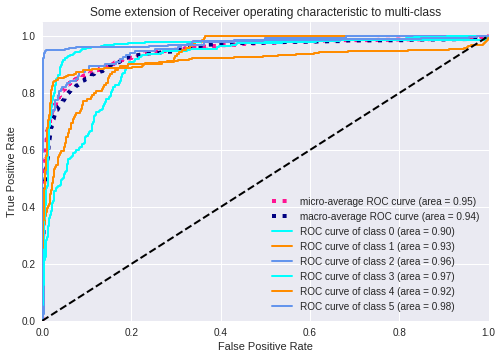

In [19]:
auc_roc_plot(one_hot(np.array(y_test_all)-1), np.array(y_score_all), None)

In [20]:
from scipy.stats import ttest_rel

In [21]:
asd = classification_report(y_test_all, y_pred_all,target_names=class_names)

In [22]:
from sklearn.metrics import precision_recall_fscore_support

In [23]:
log_first = [0.71, 0.31, 0.64, 0.87, 0.79, 0.66]
svm = [0.64, 0.34, 0.66, 0.89, 0.73, 0.61]
log_with_l1 = [0.62, 0.50, 0.68, 0.80, 0.70, 0.69]
LSTM = [0.72, 0.64, 0.83, 0.91, 0.82, 0.75]

In [24]:
from __future__ import print_function
print("LSTM and logistic regression",ttest_rel( LSTM, log_first))
print("SVM and logistic regression",ttest_rel( svm, log_first))
print("LSTM and SVM regression",ttest_rel( LSTM, svm))
print("Regularized logistic regression and logistic regression",ttest_rel( log_with_l1, log_first))
print("SVM and regularized logistic regression ",ttest_rel( svm, log_with_l1))
print("LSTM and  regularized logistic regression ",ttest_rel( LSTM, log_with_l1))

LSTM and logistic regression Ttest_relResult(statistic=2.2795753232178946, pvalue=0.0715760891707832)
SVM and logistic regression Ttest_relResult(statistic=-0.9715131257528842, pvalue=0.37591226226396834)
LSTM and SVM regression Ttest_relResult(statistic=3.3782048766027235, pvalue=0.01971268036922469)
Regularized logistic regression and logistic regression Ttest_relResult(statistic=0.03736653621201262, pvalue=0.9716387452404694)
SVM and regularized logistic regression  Ttest_relResult(statistic=-0.5518772761391626, pvalue=0.6047904840029745)
LSTM and  regularized logistic regression  Ttest_relResult(statistic=8.664002254439643, pvalue=0.0003385619641760942)


In [26]:

from sklearn import decomposition

In [27]:
X = df[df.columns[:-3]].values

In [28]:
pca = decomposition.PCA()
pca.fit(X)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

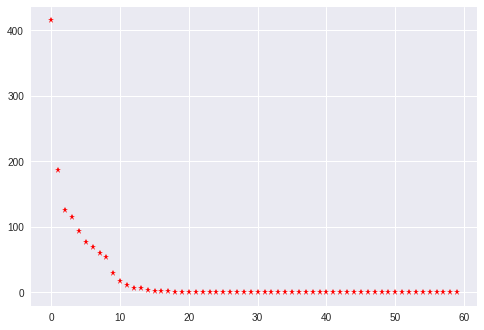

In [29]:
plt.plot(pca.explained_variance_, 'r*')

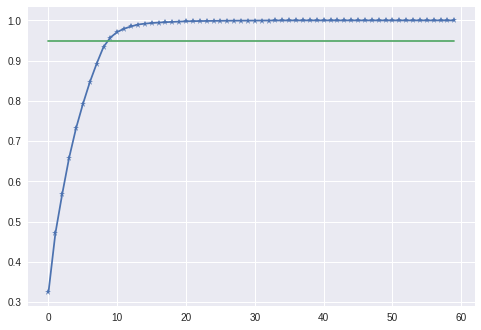

In [30]:
plt.plot(pca.explained_variance_ratio_.cumsum(), "-*")
plt.plot([0.95]*pca.explained_variance_ratio_.shape[0])

In [31]:
X = pca.transform(X)

In [32]:
colors  = np.array(["red","green","blue","orange","purple","pink","yellow"])
colors[np.array([0,1,2,3])]

array(['red', 'green', 'blue', 'orange'], dtype='|S6')

In [33]:
colors[(df['label'].values-1).astype(int)]

array(['purple', 'purple', 'purple', ..., 'red', 'red', 'red'],
      dtype='|S6')

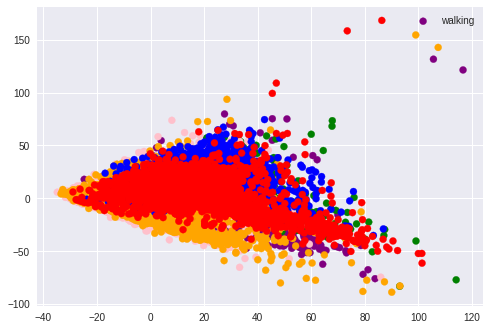

In [34]:
plt.scatter(X[:,0], X[:,1], c=colors[(df['label'].values-1).astype(int)])
plt.legend(LABELS)